#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>Cuaderno de notas</font><br>
<font size=3>Evaluación de distintas redes pre entrenadas</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [ ]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [ ]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"



Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Fina

## Importación de librerías necesarias para el notebook

In [ ]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba,

In [ ]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Chequeo de cantidad de imágenes cargadas en cada directorio.

In [ ]:
cataract_images = glob.glob(train_dir+"/Cataract/*.jpg")
diabetic_retinopathy_images = glob.glob(train_dir+"/Diabetic_Retinopathy/*.jpg")
glaucoma_images = glob.glob(train_dir+"/Glaucoma/*.jpg")
healthy_images = glob.glob(train_dir+"/Healthy/*.jpg")
macular_scar_images = glob.glob(train_dir+"/Macular_Scar/*.jpg")
myopia_images = glob.glob(train_dir+"/Myopia/*.jpg")

print(len(cataract_images))
print(len(diabetic_retinopathy_images))
print(len(glaucoma_images))
print(len(healthy_images))
print(len(macular_scar_images))
print(len(myopia_images))

732
1056
944
717
933
1050


## Generamos un grafico de torta para ver la cantidad de imagenes

De esta forma se puede observar la distribución de clases y el balanceo de clases.

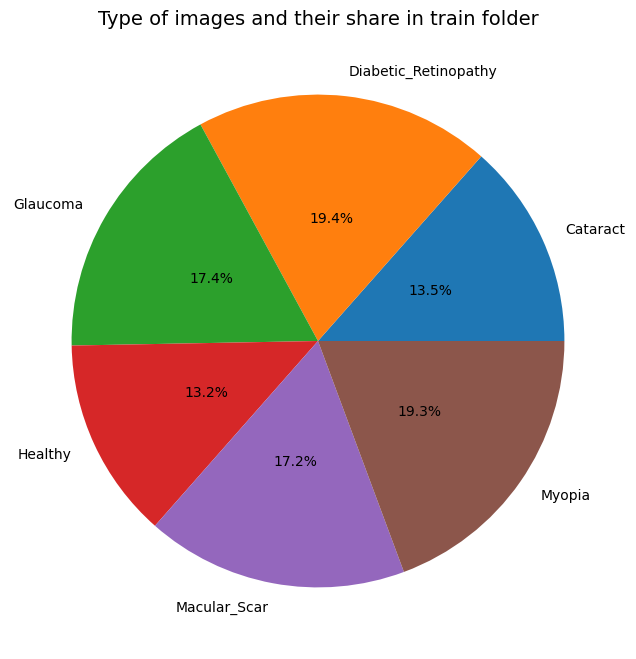

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(x=np.array([len(cataract_images), len(diabetic_retinopathy_images), len(glaucoma_images),
                    len(healthy_images), len(macular_scar_images),len(myopia_images)
                    ]), autopct="%.1f%%", labels=["Cataract", "Diabetic_Retinopathy", "Glaucoma",
                                                  "Healthy", "Macular_Scar", "Myopia"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(13,13))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(13,13))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo VGG19

Se utiliza la red preentrenada VGG19

In [ ]:
base_model = tf.keras.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


modelvgg = Sequential()
modelvgg.add(base_model)
modelvgg.add(GlobalAveragePooling2D())
modelvgg.add(Dense(2048, activation = 'relu'))
modelvgg.add(Dense(4096, activation = 'sigmoid'))
modelvgg.add(Dense(2048, activation = 'relu'))
modelvgg.add(Dense(6, activation='softmax'))
modelvgg.summary()

modelvgg.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historyvgg = modelvgg.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_5 (Dense)             (None, 4096)              8392704   
                                                                 
 dense_6 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_7 (Dense)             (None, 6)                 12294     
                                                      

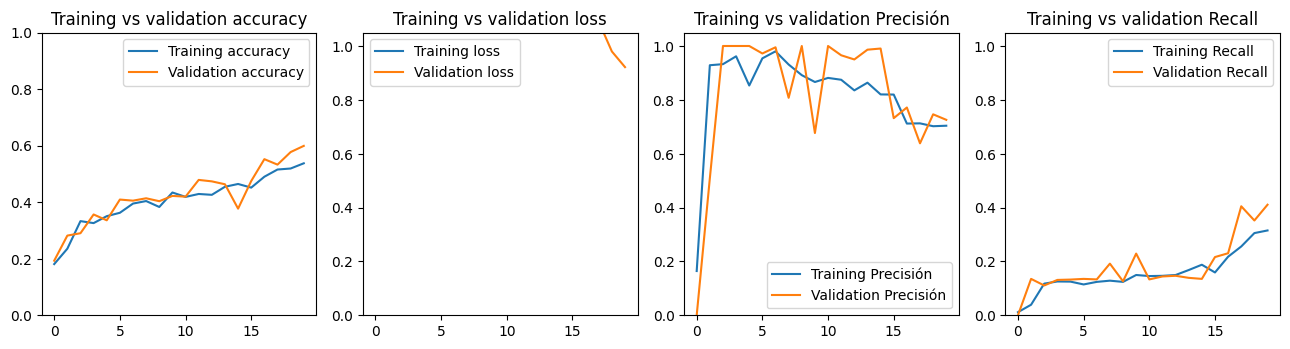

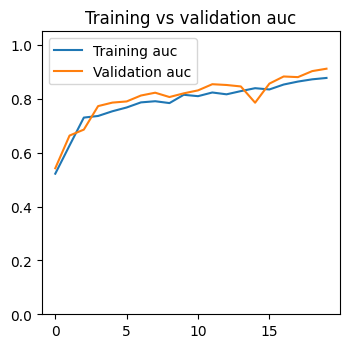

In [ ]:
graph(historyvgg)

39/39 [==============================] - 18s 461ms/step


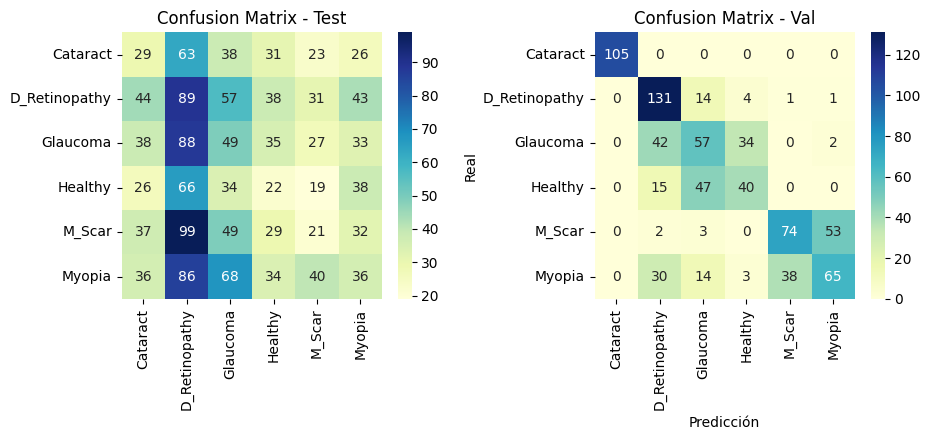

In [ ]:
y_pred9_test = modelvgg.predict(test_generator)
y_pred9_val = modelvgg.predict(validation_generator)
cf_matrix(y_pred9_test, test_generator.classes, y_pred9_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modelvgg, y_pred9_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modelvgg, y_pred9_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.18      0.29      0.22       302
           2       0.17      0.18      0.17       270
           3       0.12      0.11      0.11       205
           4       0.13      0.08      0.10       267
           5       0.17      0.12      0.14       300

    accuracy                           0.16      1554
   macro avg       0.15      0.15      0.15      1554
weighted avg       0.15      0.16      0.15      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.60      0.87      0.71       151
           2       0.42      0.42      0.42       135
           3       0.49      0.39      0.44       102
           4       0.65      0.56      0.60       132
           5       0.54      0.43      0.48       150

    accuracy                           0.61       775
   macro avg       0.62

## Modelo v50

Se utiliza la red preentrenada ResNet50

In [ ]:
base_modelv50 = tf.keras.applications.ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_modelv50.layers:
    layer.trainable = False


modelv50 = Sequential()
modelv50.add(base_modelv50)
modelv50.add(GlobalAveragePooling2D())
modelv50.add(Dense(2056, activation = 'relu'))
modelv50.add(Dense(1024, activation = 'relu'))
modelv50.add(Dense(512, activation = 'relu'))
modelv50.add(Dense(256, activation = 'relu'))
modelv50.add(Dense(6, activation='softmax'))
modelv50.summary()

modelv50.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historyv50 = modelv50.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 2056)              4212744   
                                                                 
 dense_9 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               

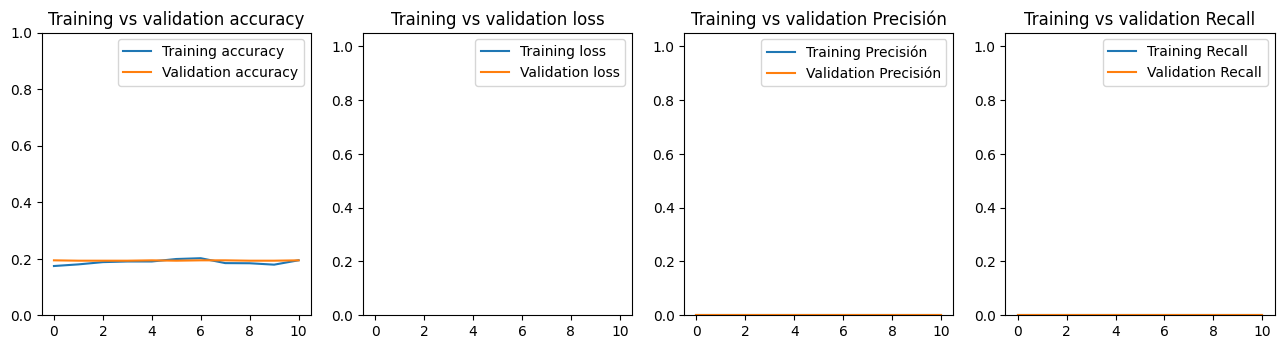

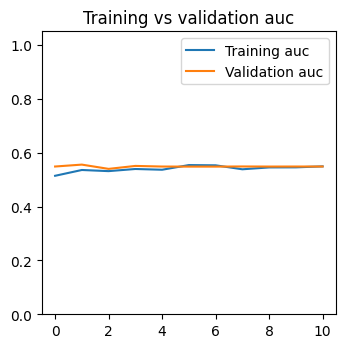

In [ ]:
graph(historyv50)

39/39 [==============================] - 14s 378ms/step


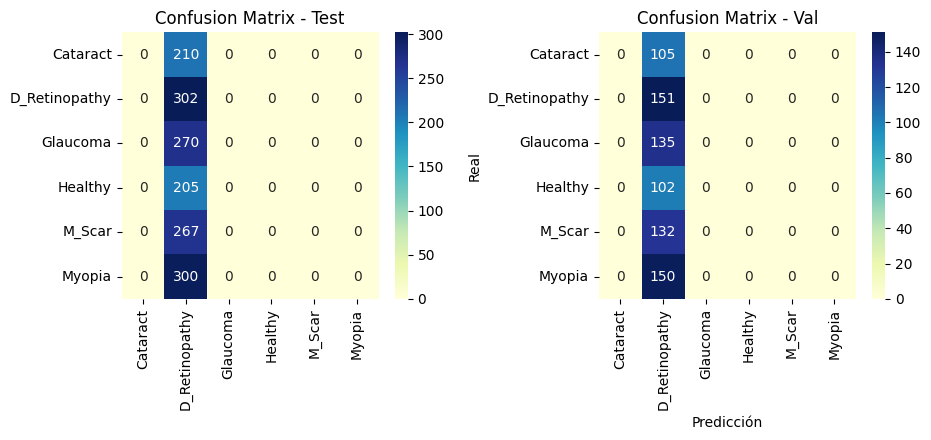

In [ ]:
y_predv50_test = modelv50.predict(test_generator)
y_predv50_val = modelv50.predict(validation_generator)
cf_matrix(y_predv50_test, test_generator.classes, y_predv50_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modelv50, y_predv50_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modelv50, y_predv50_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.19      1.00      0.33       302
           2       0.00      0.00      0.00       270
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00       267
           5       0.00      0.00      0.00       300

    accuracy                           0.19      1554
   macro avg       0.03      0.17      0.05      1554
weighted avg       0.04      0.19      0.06      1554

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.19      1.00      0.33       151
           2       0.00      0.00      0.00       135
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00       132
           5       0.00      0.00      0.00       150

    accuracy                           0.19       775
   macro avg       0.03

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

## Modelo 152V2

Se utiliza la red preentrenada ResNet152V2

In [ ]:
base_model = tf.keras.applications.ResNet152V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


model152v2 = Sequential()
model152v2.add(base_model)
model152v2.add(GlobalAveragePooling2D())
model152v2.add(Dense(2056, activation = 'relu'))
model152v2.add(Dense(1024, activation = 'relu'))
model152v2.add(Dense(512, activation = 'relu'))
model152v2.add(Dense(256, activation = 'relu'))
model152v2.add(Dense(6, activation='softmax'))
model152v2.summary()

model152v2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history152v2 = model152v2.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 2056)              4212744   
                                                                 
 dense_19 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                      

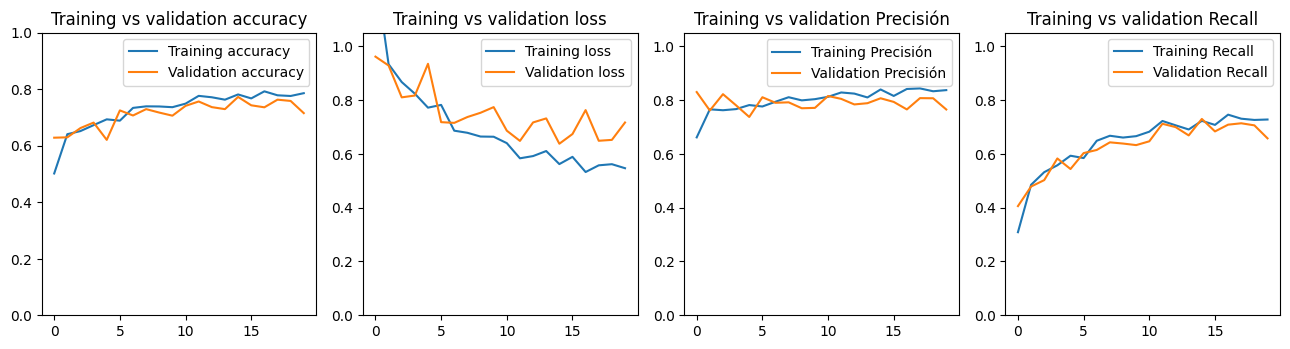

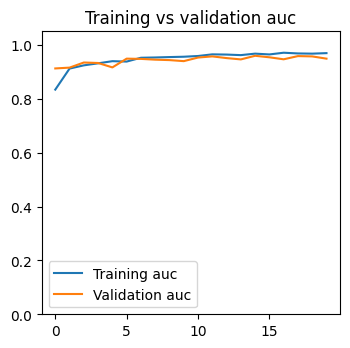

In [ ]:
graph(history152v2)

39/39 [==============================] - 15s 390ms/step


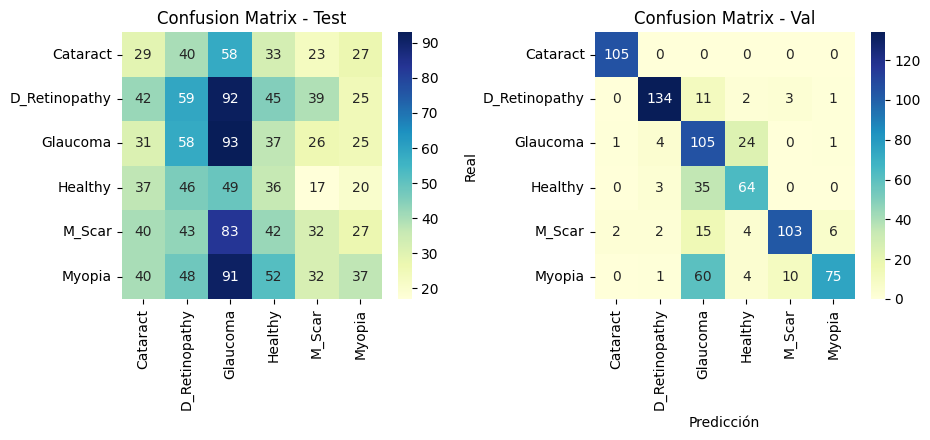

In [ ]:
y_predv152_test = model152v2.predict(test_generator)
y_predv152_val = model152v2.predict(validation_generator)
cf_matrix(y_predv152_test, test_generator.classes, y_predv152_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(history152v2, y_predv152_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(history152v2, y_predv152_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.14      0.14       210
           1       0.20      0.20      0.20       302
           2       0.20      0.34      0.25       270
           3       0.15      0.18      0.16       205
           4       0.19      0.12      0.15       267
           5       0.23      0.12      0.16       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.19      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.93      0.89      0.91       151
           2       0.46      0.78      0.58       135
           3       0.65      0.63      0.64       102
           4       0.89      0.78      0.83       132
           5       0.90      0.50      0.64       150

    accuracy                           0.76       775
   macro avg       0.80

## Modelo DenseNet201

Se utiliza la red preentrenada DenseNet201

In [ ]:
base_model = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


modeldn201 = Sequential()
modeldn201.add(base_model)
modeldn201.add(GlobalAveragePooling2D())
modeldn201.add(Dense(2056, activation = 'relu'))
modeldn201.add(Dense(1024, activation = 'relu'))
modeldn201.add(Dense(512, activation = 'relu'))
modeldn201.add(Dense(256, activation = 'relu'))
modeldn201.add(Dense(6, activation='softmax'))
modeldn201.summary()

modeldn201.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historydn201 = modeldn201.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 2056)              3949576   
                                                                 
 dense_6 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 256)               

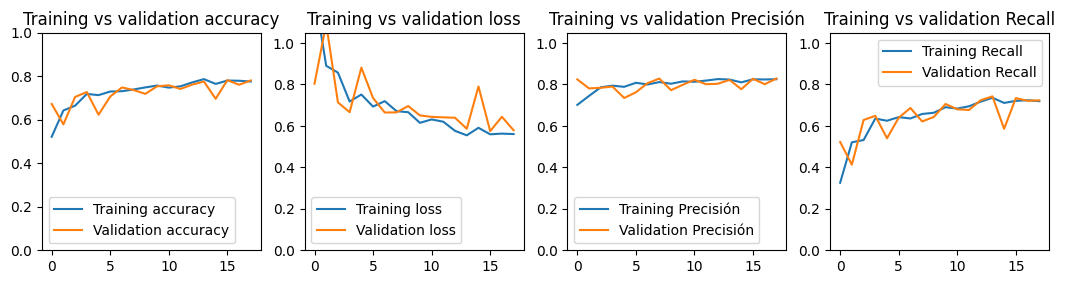

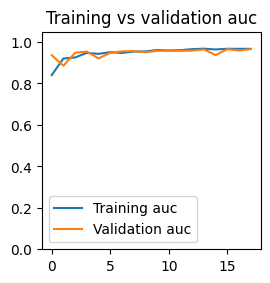

In [ ]:
graph(historydn201)

39/39 [==============================] - 17s 450ms/step


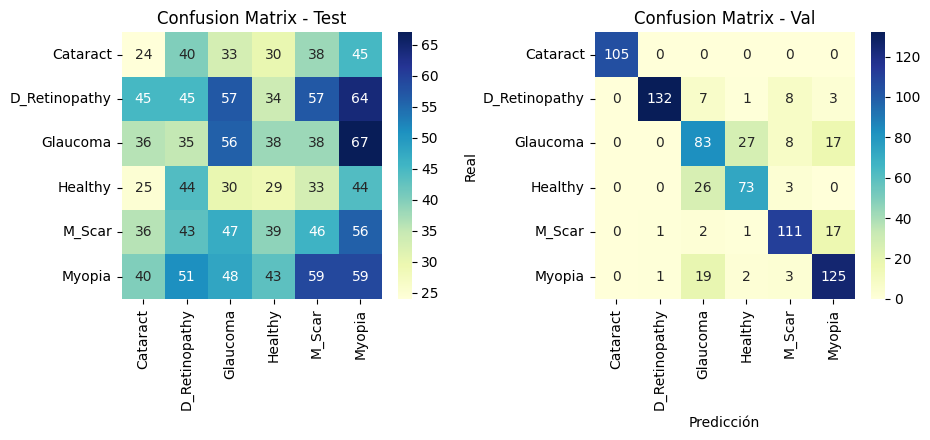

In [ ]:
y_preddn201_test = modeldn201.predict(test_generator)
y_preddn201_val = modeldn201.predict(validation_generator)
cf_matrix(y_preddn201_test, test_generator.classes, y_preddn201_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(historydn201, y_preddn201_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(historydn201, y_preddn201_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.11      0.12       210
           1       0.17      0.15      0.16       302
           2       0.21      0.21      0.21       270
           3       0.14      0.14      0.14       205
           4       0.17      0.17      0.17       267
           5       0.18      0.20      0.19       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.99      0.87      0.93       151
           2       0.61      0.61      0.61       135
           3       0.70      0.72      0.71       102
           4       0.83      0.84      0.84       132
           5       0.77      0.83      0.80       150

    accuracy                           0.81       775
   macro avg       0.82

## Modelo EffNetV2L

Se utiliza la red preentrenada EfficientNetV2L

In [ ]:
base_model = tf.keras.applications.EfficientNetV2L(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


modeleffNet = Sequential()
modeleffNet.add(base_model)
modeleffNet.add(GlobalAveragePooling2D())
modeleffNet.add(Dense(2056, activation = 'relu'))
modeleffNet.add(Dense(1024, activation = 'relu'))
modeleffNet.add(Dense(512, activation = 'relu'))
modeleffNet.add(Dense(256, activation = 'relu'))
modeleffNet.add(Dense(6, activation='softmax'))
modeleffNet.summary()

modeleffNet.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historyeffNet = modeleffNet.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

473176280/473176280 [==============================] - 6s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 7, 7, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 2056)              2633736   
                                                                 
 dense_16 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                     

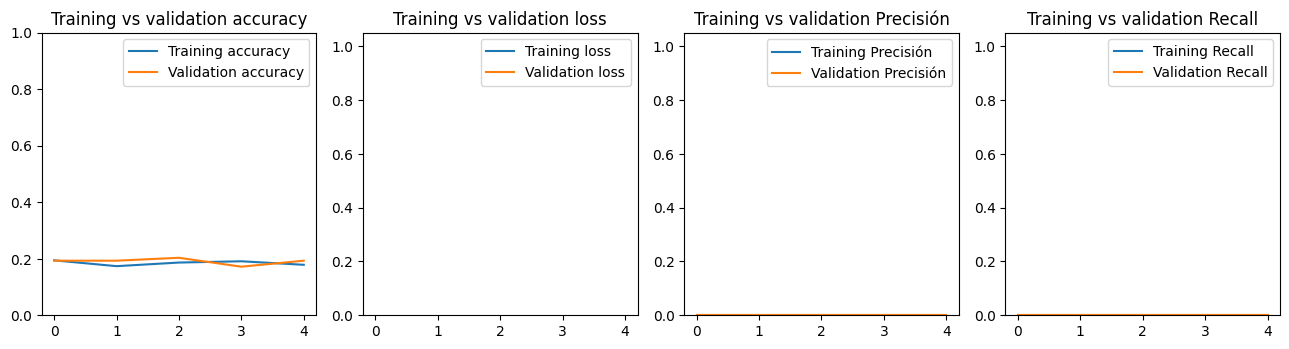

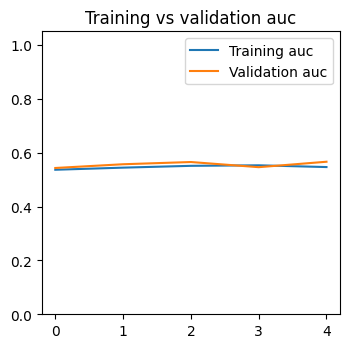

In [ ]:
graph(historyeffNet)

39/39 [==============================] - 17s 443ms/step


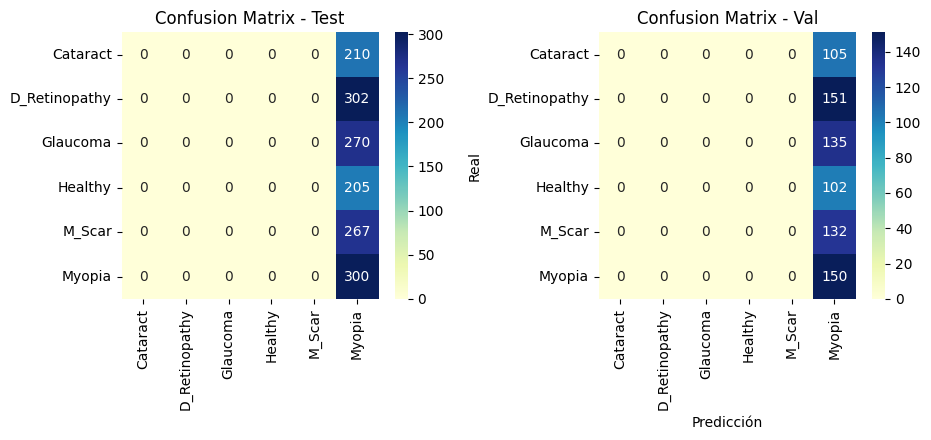

In [ ]:
y_predeffNet_test = modeleffNet.predict(test_generator)
y_predeffNet_val = modeleffNet.predict(validation_generator)
cf_matrix(y_predeffNet_test, test_generator.classes, y_predeffNet_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modeleffNet, y_predeffNet_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modeleffNet, y_predeffNet_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.00      0.00      0.00       302
           2       0.00      0.00      0.00       270
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00       267
           5       0.19      1.00      0.32       300

    accuracy                           0.19      1554
   macro avg       0.03      0.17      0.05      1554
weighted avg       0.04      0.19      0.06      1554

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.00      0.00      0.00       151
           2       0.00      0.00      0.00       135
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00       132
           5       0.19      1.00      0.32       150

    accuracy                           0.19       775
   macro avg       0.03

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

## Modelo IRN

Se utiliza la red preentrenada InceptionResNetV2

Esta red requiere que el inpute_shape se ajuste a 299,299. Por este motivo se vuelven a cargar los ImageDataGenerator con los valores correctos.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (299, 299))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(299, 299))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(299, 299))

input_shape = (299, 299, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


modelirn = Sequential()
modelirn.add(base_model)
modelirn.add(GlobalAveragePooling2D())
modelirn.add(Dense(2056, activation = 'relu'))
modelirn.add(Dense(1024, activation = 'relu'))
modelirn.add(Dense(512, activation = 'relu'))
modelirn.add(Dense(256, activation = 'relu'))
modelirn.add(Dense(6, activation='softmax'))
modelirn.summary()

modelirn.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historyirn = modelirn.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_5  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 2056)              3160072   
                                                                 
 dense_24 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                     

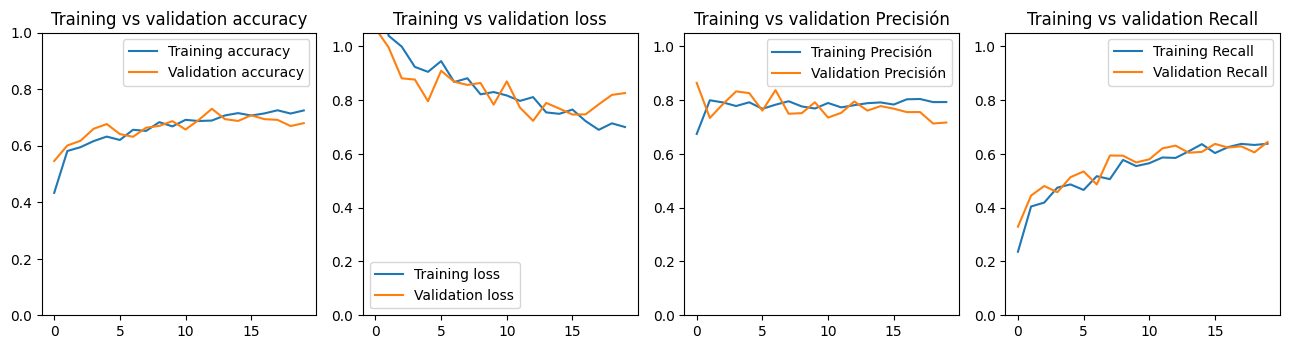

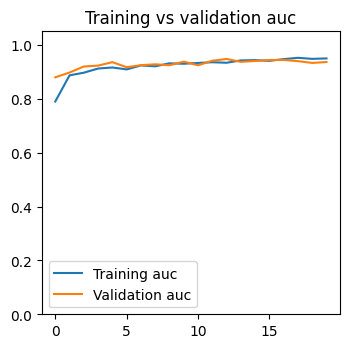

In [ ]:
graph(historyirn)

39/39 [==============================] - 19s 502ms/step


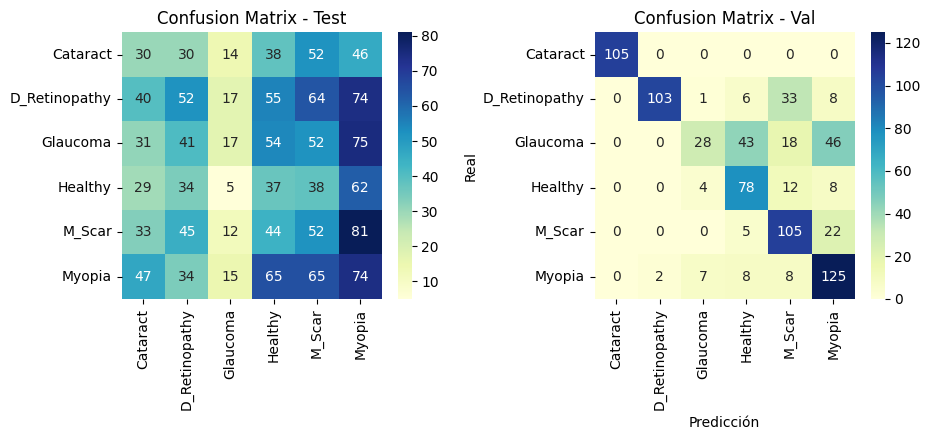

In [ ]:
y_predvirn_test = modelirn.predict(test_generator)
y_predvirn_val = modelirn.predict(validation_generator)
cf_matrix(y_predvirn_test, test_generator.classes, y_predvirn_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modelirn, y_predvirn_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modelirn, y_predvirn_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.22      0.17      0.19       302
           2       0.21      0.06      0.10       270
           3       0.13      0.18      0.15       205
           4       0.16      0.19      0.18       267
           5       0.18      0.25      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.18      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.98      0.68      0.80       151
           2       0.70      0.21      0.32       135
           3       0.56      0.76      0.64       102
           4       0.60      0.80      0.68       132
           5       0.60      0.83      0.70       150

    accuracy                           0.70       775
   macro avg       0.74

## Modelo V3

Se utiliza la red preentrenada InceptionV3

In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


modelv3 = Sequential()
modelv3.add(base_model)
modelv3.add(GlobalAveragePooling2D())
modelv3.add(Dense(2056, activation = 'relu'))
modelv3.add(Dense(1024, activation = 'relu'))
modelv3.add(Dense(512, activation = 'relu'))
modelv3.add(Dense(256, activation = 'relu'))
modelv3.add(Dense(6, activation='softmax'))
modelv3.summary()

modelv3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historyv3 = modelv3.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_28 (Dense)            (None, 2056)              4212744   
                                                                 
 dense_29 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_30 (Dense)            (None, 512)               524800    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                      

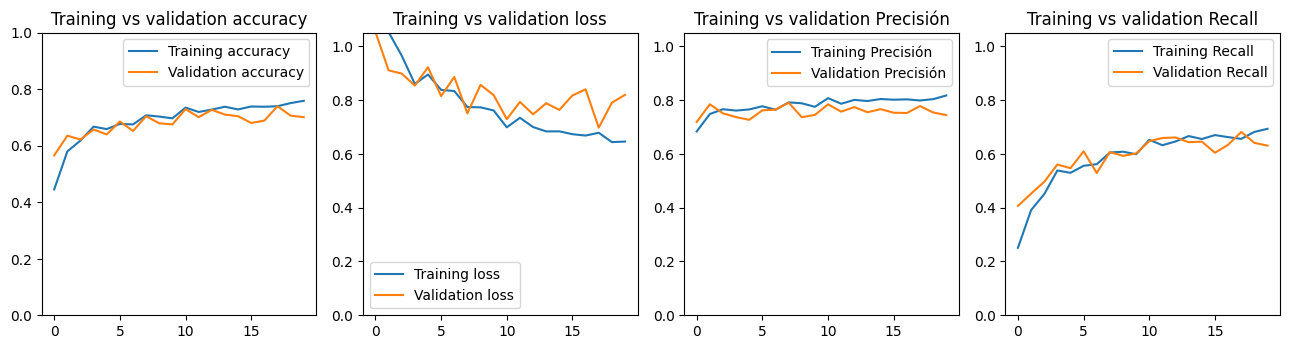

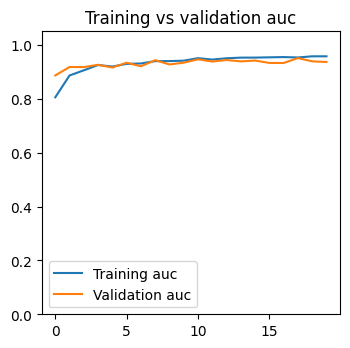

In [ ]:
graph(historyv3)

39/39 [==============================] - 16s 423ms/step


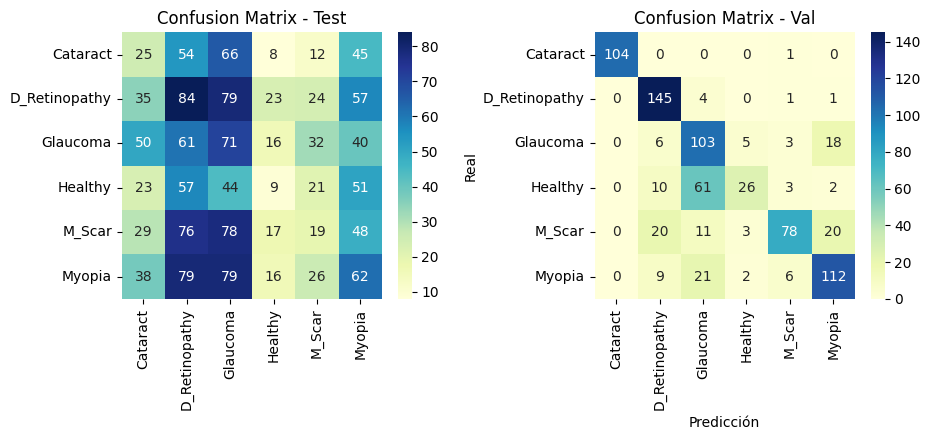

In [ ]:
y_predv3_test = modelv3.predict(test_generator)
y_predv3_val = modelv3.predict(validation_generator)
cf_matrix(y_predv3_test, test_generator.classes, y_predv3_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modelv3, y_predv3_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modelv3, y_predv3_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.20      0.28      0.24       302
           2       0.17      0.26      0.21       270
           3       0.10      0.04      0.06       205
           4       0.14      0.07      0.09       267
           5       0.20      0.21      0.21       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.16      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.76      0.96      0.85       151
           2       0.52      0.76      0.61       135
           3       0.72      0.25      0.38       102
           4       0.85      0.59      0.70       132
           5       0.73      0.75      0.74       150

    accuracy                           0.73       775
   macro avg       0.76

## Modelo Nas

Se utiliza la red preentrenada NASNetLarge

Esta red requiere que el inpute_shape se ajuste a 331,331. Por este motivo se vuelven a cargar los ImageDataGenerator con los valores correctos.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (331, 331))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(331, 331))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(331, 331))

input_shape = (331, 331, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


In [ ]:
base_model = tf.keras.applications.NASNetLarge(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


modelnas = Sequential()
modelnas.add(base_model)
modelnas.add(GlobalAveragePooling2D())
modelnas.add(Dense(2056, activation = 'relu'))
modelnas.add(Dense(1024, activation = 'relu'))
modelnas.add(Dense(512, activation = 'relu'))
modelnas.add(Dense(256, activation = 'relu'))
modelnas.add(Dense(6, activation='softmax'))
modelnas.summary()

modelnas.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historynas = modelnas.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

343610240/343610240 [==============================] - 7s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d_8  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_38 (Dense)            (None, 2056)              8291848   
                                                                 
 dense_39 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_40 (Dense)            (None, 512)               524800    
                                                                 
 dense_41 (Dense)            (None, 256)             

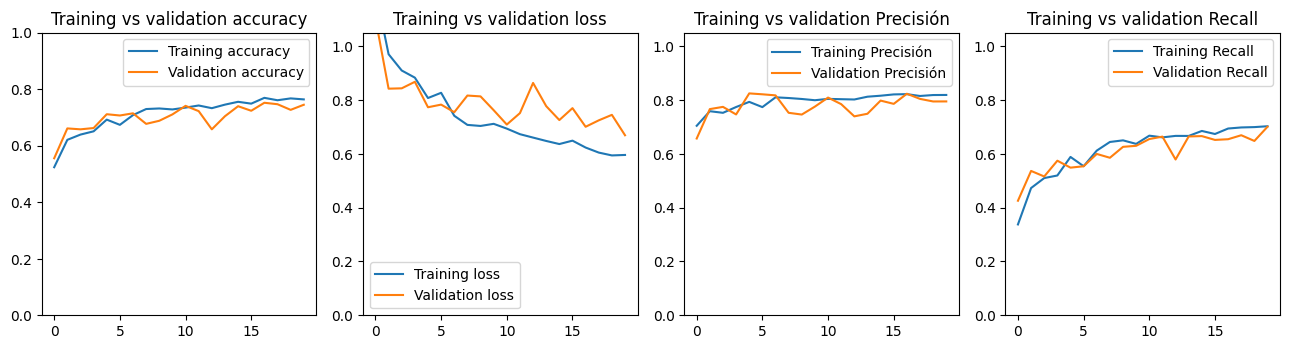

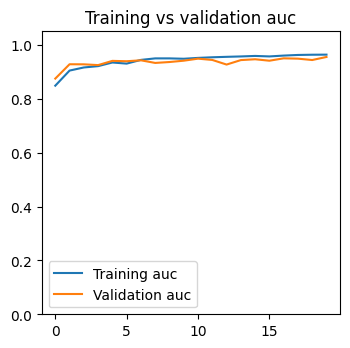

In [ ]:
graph(historynas)

In [ ]:
y_prednas_test = modelnas.predict(test_generator)
y_prednas_val = modelnas.predict(validation_generator)
cf_matrix(y_prednas_test, test_generator.classes, y_prednas_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modelnas, y_prednas_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modelnas, y_prednas_val, validation_generator.classes)
print(reporte)

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(modelvgg)

Evaluar con Entrenamiento:
272/272 [==============================] - 153s 560ms/step - loss: 0.9933 - accuracy: 0.5527 - precision: 0.7133 - recall: 0.3765 - auc: 0.8957
Evaluar con Validación:
78/78 [==============================] - 27s 338ms/step - loss: 0.9215 - accuracy: 0.5991 - precision: 0.7258 - recall: 0.4106 - auc: 0.9115
Evaluar con Prueba:
39/39 [==============================] - 14s 350ms/step - loss: 0.8541 - accuracy: 0.6090 - precision: 0.7231 - recall: 0.4516 - auc: 0.9220


In [ ]:
evaluar_modelo(modelv50)

Evaluar con Entrenamiento:
272/272 [==============================] - 151s 555ms/step - loss: 1.7802 - accuracy: 0.1944 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5487
Evaluar con Validación:
78/78 [==============================] - 27s 343ms/step - loss: 1.7803 - accuracy: 0.1943 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5485
Evaluar con Prueba:
39/39 [==============================] - 13s 347ms/step - loss: 1.7802 - accuracy: 0.1948 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5489


In [ ]:
evaluar_modelo(model152v2)

Evaluar con Entrenamiento:
272/272 [==============================] - 159s 585ms/step - loss: 0.6233 - accuracy: 0.7401 - precision: 0.7840 - recall: 0.6983 - auc: 0.9606
Evaluar con Validación:
78/78 [==============================] - 28s 354ms/step - loss: 0.7159 - accuracy: 0.7149 - precision: 0.7642 - recall: 0.6570 - auc: 0.9489
Evaluar con Prueba:
39/39 [==============================] - 14s 372ms/step - loss: 0.6210 - accuracy: 0.7561 - precision: 0.7974 - recall: 0.7006 - auc: 0.9602


In [ ]:
evaluar_modelo(modeldn201)

Evaluar con Entrenamiento:
272/272 [==============================] - 178s 656ms/step - loss: 0.5024 - accuracy: 0.8049 - precision: 0.8501 - recall: 0.7415 - auc: 0.9746
Evaluar con Validación:
78/78 [==============================] - 26s 335ms/step - loss: 0.5790 - accuracy: 0.7806 - precision: 0.8289 - recall: 0.7233 - auc: 0.9658
Evaluar con Prueba:
39/39 [==============================] - 13s 331ms/step - loss: 0.4650 - accuracy: 0.8116 - precision: 0.8445 - recall: 0.7639 - auc: 0.9775


In [ ]:
evaluar_modelo(modeleffNet)

Evaluar con Entrenamiento:
272/272 [==============================] - 161s 590ms/step - loss: 1.7744 - accuracy: 0.1955 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5648
Evaluar con Validación:
78/78 [==============================] - 29s 362ms/step - loss: 1.7744 - accuracy: 0.1931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5662
Evaluar con Prueba:
39/39 [==============================] - 15s 378ms/step - loss: 1.7745 - accuracy: 0.1935 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5665


In [ ]:
evaluar_modelo(modelirn)

Evaluar con Entrenamiento:
272/272 [==============================] - 229s 842ms/step - loss: 0.7291 - accuracy: 0.7211 - precision: 0.7682 - recall: 0.6730 - auc: 0.9474
Evaluar con Validación:
78/78 [==============================] - 34s 435ms/step - loss: 0.8252 - accuracy: 0.6795 - precision: 0.7158 - recall: 0.6435 - auc: 0.9364
Evaluar con Prueba:
39/39 [==============================] - 17s 428ms/step - loss: 0.7955 - accuracy: 0.7019 - precision: 0.7511 - recall: 0.6619 - auc: 0.9424


In [ ]:
evaluar_modelo(modelv3)

Evaluar con Entrenamiento:
272/272 [==============================] - 210s 769ms/step - loss: 0.6743 - accuracy: 0.7253 - precision: 0.7794 - recall: 0.6633 - auc: 0.9538
Evaluar con Validación:
78/78 [==============================] - 29s 376ms/step - loss: 0.8185 - accuracy: 0.7008 - precision: 0.7434 - recall: 0.6300 - auc: 0.9364
Evaluar con Prueba:
39/39 [==============================] - 16s 414ms/step - loss: 0.6724 - accuracy: 0.7329 - precision: 0.7829 - recall: 0.6748 - auc: 0.9543


In [ ]:
evaluar_modelo(modelnas)

Evaluar con Entrenamiento:
272/272 [==============================] - 301s 1s/step - loss: 0.5655 - accuracy: 0.7795 - precision: 0.8272 - recall: 0.7349 - auc: 0.9673
Evaluar con Validación:
78/78 [==============================] - 46s 586ms/step - loss: 0.6685 - accuracy: 0.7445 - precision: 0.7942 - recall: 0.7001 - auc: 0.9551
Evaluar con Prueba:
39/39 [==============================] - 26s 659ms/step - loss: 0.6970 - accuracy: 0.7484 - precision: 0.7997 - recall: 0.7058 - auc: 0.9522
